### **Generate Point Sources with the given algorithm**

#### **Parts:**
- Number of PS
- Restrict S range and interpolate to get more data
- Rejection sampling method 
- CDF method
- Plotting and comparison

In [1]:
from diff_number_counts import number_above, dNdS_total
from scipy.integrate import cumtrapz
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt

#### **1. Number of PS**

In [2]:
# Limit on S [Jy]
S_min = 1e-03
S_max = 10
nu = 27 # Simons Observatory. Units in GHz
number_ps = number_above(S_min, S_max, nu)
number_ps = int(number_ps.value)
print(f'The total number of point sources is {number_ps}')

The total number of point sources is 3152091


##### ***Small comment***

In [3]:
# why if Smax is larger, the number of PS decrease? 
# Ex:
print(f'The total number of point sources for Smax = 12 is {number_above(10e-03,12,nu,)} whereas the number of point sources for Smax = 10 is {number_ps}.'
      f'\nThe wider the S range the less number of point sources?')

# Patricia: En principio aumentar Smax debería aumentarte el número de fuentes, nunca disminuirlo. No sé qué puede estar pasando. 
# Se me ocurre que pueda ser un fallo de integración numérica. Si es una integral tipo simpson o trapz, puede que al cambiar Smax estés cambiando los 
# intervalos de valores x que internamente usa para evaluar e integrar la función.

The total number of point sources for Smax = 12 is 401084.16854798043 1 / rad2 whereas the number of point sources for Smax = 10 is 3152091.
The wider the S range the less number of point sources?


#### **2. Restrict S range and interpolate to get more data**

In [4]:
# Get dNdS and S in the entire range
dNdS_val = dNdS_total(nu) 
S_orig = dNdS_val[0] 
dNdS_orig = dNdS_val[1] * 4 * np.pi # dNdS is the number of PS per steradian between s and s+ds. We multiply by 4π to obtain the number of total PS in s and s+ds

# Restrict dNdS and S to the desired range
mask = (S_orig >= S_min) & (S_orig <= S_max)
S_restricted = S_orig[mask]
dNdS_restricted = dNdS_orig[mask]

##### *Previously, we were using the entire range of values in dNdS_orig to generate the random numbers for the flux values, i.e., [1e-5, 1e2] Jy. This included values outside the desired range of [1e-03, 10] Jy resulting in some generated flux values that were outside the desired range. To solve this, we can first restrict dNdS_orig to the desired range.*

In [5]:
# Interpolate to get more data
# Convert to log
S_restricted_log = np.log10(S_restricted)
dNdS_restricted_log = np.log10(dNdS_restricted)

# Define the new range of S_restricted_log values you want
new_S_restricted_log = np.arange(np.min(S_restricted_log), np.max(S_restricted_log), 0.01)

# Interpolate the dNdS_restricted_log values onto the new S_restricted_log values
spl = UnivariateSpline(S_restricted_log, dNdS_restricted_log, s=0)
new_dNdS_restricted_log = spl(new_S_restricted_log)

# Take out the log
S_restricted = 10**new_S_restricted_log
dNdS_restricted = 10**new_dNdS_restricted_log

#### **3. Rejection sampling method (too slow)**

```
x_min, x_max = np.min(S_restricted), np.max(S_restricted)
y_min, y_max = np.min(dNdS_restricted), np.max(dNdS_restricted)

curve = UnivariateSpline(S_restricted, dNdS_restricted, s=0)

# Set batch size
batch_size = 10000

# Rejection sampling
x_below = []
y_below = []
while len(x_below) < number_ps:
    # Generate batch of random samples
    x_batch = np.random.uniform(x_min, x_max, size=batch_size)
    y_batch = np.random.uniform(y_min, y_max, size=batch_size)
    
    # Evaluate curve on batch of samples
    curve_batch = curve(x_batch)
    
    # Find indices of samples below curve
    idx_below = np.where(y_batch <= curve_batch)[0]
    
    # Append samples below curve to x_below and y_below
    x_below.extend(x_batch[idx_below])
    y_below.extend(y_batch[idx_below])
```

#### **4. CDF method**

The cumulative distribution function (CDF) of a real-valued random variable X evaluated at x, is the probability that X will take a value less than or equal to x _(Wikipedia)_.
\begin{equation}
F_X(x)=\mathrm{P}(X \leq x)
\end{equation}
This gives us a function that maps S values to probabilities, which we can use to generate random flux densities from the restricted dNdS distribution.

In [6]:
dNdS_cum = cumtrapz(dNdS_restricted, S_restricted, initial=0) # CDF. Initial value of the cumulative integral set as 0
norm = dNdS_cum[-1]
dNdS_norm = dNdS_restricted/norm
dNdS_norm_cum = cumtrapz(dNdS_norm, S_restricted, initial=0)

# Generate random flux values 
f = UnivariateSpline(dNdS_norm_cum, S_restricted, s=0) # Creates a function f that maps from a probability value p to the corresponding flux density value S such that f(p) = S (inverse CDF)
S_new = f(np.random.uniform(size=(number_ps))) # Map each probability to the corresponding S
S_new = np.clip(S_new, S_min, S_max) # interp1d is not limited to generate S_new in the range (1e-03, 10). It can generate S_new values outside this range as well.

#### **5. Plotting and comparison**

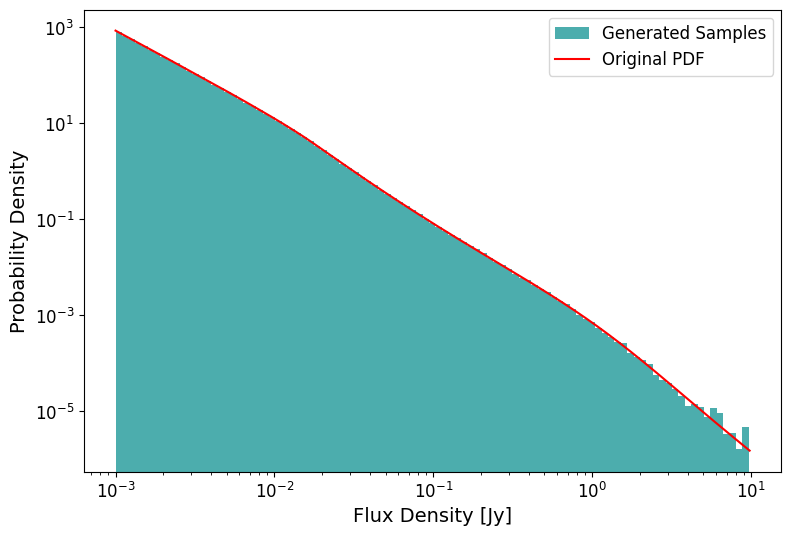

In [7]:
bins = np.logspace(np.log10(np.min(S_new)), np.log10(np.max(S_new)), num=100)
fig, ax = plt.subplots(figsize=(9, 6))

ax.hist(S_new, bins=bins, density=True, label='Generated Samples', alpha=0.7, color='darkcyan')

ax.set_xscale('log')
ax.set_yscale('log')

integral = np.trapz(dNdS_restricted, S_restricted)
ax.plot(S_restricted, dNdS_restricted/integral, label='Original PDF', color='red')

ax.set_xlabel('Flux Density [Jy]', fontsize=14)
ax.set_ylabel('Probability Density', fontsize = 14)

ax.legend(fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('Flux_Density_Distribution.jpg', dpi = 150)

plt.show()


In [8]:
%store S_new
del S_new # This will DELETE the data from the memory of the first notebook

Stored 'S_new' (ndarray)


In [9]:
%store number_ps
del number_ps 

Stored 'number_ps' (int)


In [10]:
%store nu
del nu 

Stored 'nu' (int)
